# Advanced Linear Regression  

This is a repo for some advanced linear regression practice. We covered basic linear regression and some of the assumptions in the previous linear regression guided practice. Here, we want to take a look at some of the important concepts to consider when building models including, 

- identifying and dealing with categorical variables
- understanding the assumptions of linear regression
- understanding the various transformations
- understanding the interpretation of coefficients
- final model validation

We will be using the **Ames housing data** from the Kaggle competition of regression techniques. This dataset is already divided into test and train sets. We will be focusing on using the train data. Now, this dataset has a large number of variables. For the sake of simplicity, we will be focusing on a select few from those. The ```data_description.txt``` file has details of all the features being provided.

The ```solution.ipynb``` notebook has the solution to this exercise. 

## Importing the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

print('- Package Versions:')
print(f'\tMatplotlib = {mpl.__version__}')
print(f'\tPandas = {pd.__version__}')
print(f'\tSeaborn = {sns.__version__}')

- Package Versions:
	Matplotlib = 3.3.2
	Pandas = 1.1.3
	Seaborn = 0.11.0


In [2]:
cols_to_use = ['YrSold', 'MoSold', 'Fireplaces', 'TotRmsAbvGrd', 'GrLivArea',
          'FullBath', 'YearRemodAdd', 'YearBuilt', 'OverallCond', 
          'OverallQual', 'LotArea', 'SalePrice','BldgType']
df = pd.read_csv("train.csv")
df = df[cols_to_use]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   YrSold        1460 non-null   int64 
 1   MoSold        1460 non-null   int64 
 2   Fireplaces    1460 non-null   int64 
 3   TotRmsAbvGrd  1460 non-null   int64 
 4   GrLivArea     1460 non-null   int64 
 5   FullBath      1460 non-null   int64 
 6   YearRemodAdd  1460 non-null   int64 
 7   YearBuilt     1460 non-null   int64 
 8   OverallCond   1460 non-null   int64 
 9   OverallQual   1460 non-null   int64 
 10  LotArea       1460 non-null   int64 
 11  SalePrice     1460 non-null   int64 
 12  BldgType      1460 non-null   object
dtypes: int64(12), object(1)
memory usage: 148.4+ KB


You will notice that we are only using specific columns from the dataset. This is done purely for managing time better. Feel free to use all the columns if you want. Also when you are working with the test data, ```test.csv``` be sure to apply these same changes to that data. Remember that you will not be provided the ```SalePrice``` for the test data. You can check out the Kaggle competition [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). If you submit the predictions, you will get to see the RMSE of your results

# EDA

What are some interesting things that we should explore here? Keep in mind that before building a model, we need to first meet some of the assumptions of regression. We also need to identify the continuous and categorical variables and also the correlation between different variables

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

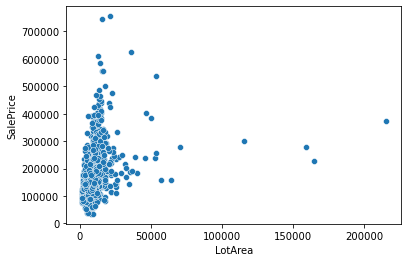

In [4]:
# EDA plots
sns.scatterplot(x = "LotArea", y = "SalePrice", data = df)

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

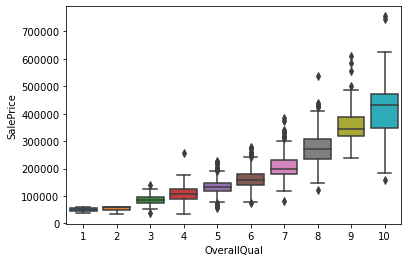

In [5]:
sns.boxplot(x = "OverallQual", y = "SalePrice", data = df)

In [6]:
df.LotArea.nunique()

1073

In [7]:
df.OverallQual.value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

In [8]:
df.OverallCond.value_counts()

5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

In [9]:
df.BldgType.value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

<AxesSubplot:>

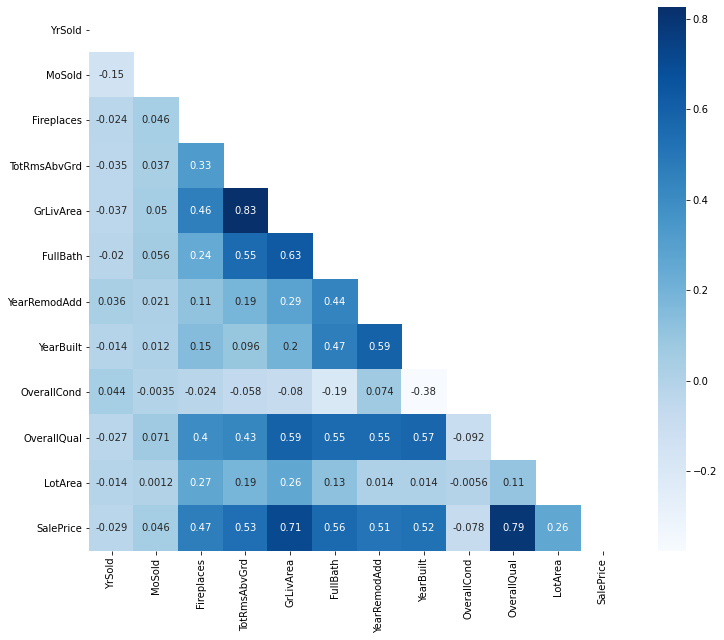

In [10]:
# heatmap
corr = df.corr()
mask = np.triu(corr)
plt.figure(figsize=(12,10))
sns.heatmap(corr, mask = mask, annot = True, cmap = 'Blues')

In [11]:
# Make lists of variables we want to use. Its a good idea to make separate lists
# for the continuous and categorical variables
conts = []
cat = []
for col in df.columns:
    if df[col].nunique() < 20:
        cat.append(col)
    else:
        conts.append(col)

In [12]:
conts

['GrLivArea', 'YearRemodAdd', 'YearBuilt', 'LotArea', 'SalePrice']

In [13]:
cat

['YrSold',
 'MoSold',
 'Fireplaces',
 'TotRmsAbvGrd',
 'FullBath',
 'OverallCond',
 'OverallQual',
 'BldgType']

In [14]:
df.loc[:, cat]

,YrSold,MoSold,Fireplaces,TotRmsAbvGrd,FullBath,OverallCond,OverallQual,BldgType
0,2008,2,0,8,2,5,7,1Fam
1,2007,5,1,6,2,8,6,1Fam
2,2008,9,1,6,2,5,7,1Fam
3,2006,2,1,7,1,5,7,1Fam
4,2008,12,1,9,2,5,8,1Fam
...,...,...,...,...,...,...,...,...
1455,2007,8,1,7,2,5,6,1Fam
1456,2010,2,2,7,2,6,6,1Fam
1457,2010,5,2,9,2,9,7,1Fam
1458,2010,4,0,5,1,6,5,1Fam


## Identifying the variables we will be using and their types

Lets make some quick plots to try and identify the variables we will be using. To start with, we want to make a baseline model. Baseline models are defined as simple models that have decent results. They are not necessarily the best models, but they are easy to build and interpret

In [15]:
# identify the top 3 variables and make a new df with them
df_baseline = df.loc[:, ['SalePrice', 'OverallQual', 'GrLivArea']]
df_baseline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   SalePrice    1460 non-null   int64
 1   OverallQual  1460 non-null   int64
 2   GrLivArea    1460 non-null   int64
dtypes: int64(3)
memory usage: 34.3 KB


# Modeling

The idea behind modeling when using linear regression is to iteratively address issues in the previous models and build better models. There are various techniques available to us to improve our results. We will cover them briefly here.

## Baseline Model

In [16]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [17]:
df_baseline

,SalePrice,OverallQual,GrLivArea
0,208500,7,1710
1,181500,6,1262
2,223500,7,1786
3,140000,7,1717
4,250000,8,2198
...,...,...,...
1455,175000,6,1647
1456,210000,6,2073
1457,266500,7,2340
1458,142125,5,1078


Lets first build the baseline model. We will use the 3 variables we selected above and build the baseline model.

In [18]:
# build the model and print the summary
y = df_baseline['SalePrice']
X = df_baseline.drop(['SalePrice'], axis = 1)


model_1 = sm.OLS(y, sm.add_constant(X)).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     1820.
Date:                Mon, 23 May 2022   Prob (F-statistic):               0.00
Time:                        15:40:07   Log-Likelihood:                -17630.
No. Observations:                1460   AIC:                         3.527e+04
Df Residuals:                    1457   BIC:                         3.528e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.041e+05   5045.372    -20.631      0.000   -1.14e+05   -9.42e+04
OverallQual  3.285e+04    999.198     32.875      0.000    3.09e+04    3.48e+04
GrLivArea      55.8622      2.630     21.242      0.000      50.704      61.021
==============================================================================
Omnibus:                      341.985   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8725.150
Skew:                           0.469   Prob(JB):                         0.00
Kurtosis:                      14.939   Cond. No.                     7.35e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Lets identify interesting things from the summary. List three observations below. Also make sure you interpret at least one coefficient.

### Model diagnostics

Determine how this model performs on the assumptions of normality of residuals and homoscedasticity by using the correct plots.

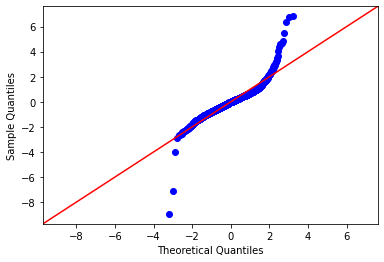

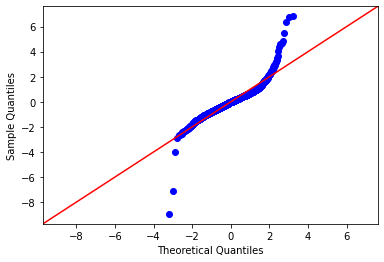

In [19]:
# model validation
sm.qqplot(model_1.resid, fit = True, line = '45')

<AxesSubplot:ylabel='Count'>

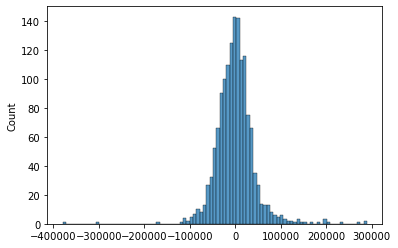

In [20]:
sns.histplot(model_1.resid)

List out your observations from the plots

## Model 2 - Including the categorical variables

Now, lets try including the categorical variables and make sure we are dealing with them correctly. Remember that there are 2 ways of dealing with categorical variables - label encoding and one hot encoding

**Label encoding**- Label Encoding refers to converting the labels into a numeric form so as to convert them into the machine-readable form. One big issue in this technique is this may lead to the generation of priority issues in the training of data sets. A label with a high value may be considered to have high priority than a label having a lower value.

**One hot encoding**- This is where the categorical variable is removed and a new binary variable is added for each unique integer value. The binary variables are often called “dummy variables” 

Lets decide which technique works here and do this for the ```BldgType``` variable

In [21]:
# deal with the BldgType variable
bldg_dummies = pd.get_dummies(df['BldgType'], prefix="bldg_type")
bldg_dummies.drop(columns = ['bldg_type_2fmCon'], inplace = True)

In [22]:
X = pd.concat([X, bldg_dummies, df['FullBath']], axis = 1)
X              

,OverallQual,GrLivArea,bldg_type_1Fam,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,FullBath
0,7,1710,1,0,0,0,2
1,6,1262,1,0,0,0,2
2,7,1786,1,0,0,0,2
3,7,1717,1,0,0,0,1
4,8,2198,1,0,0,0,2
...,...,...,...,...,...,...,...
1455,6,1647,1,0,0,0,2
1456,6,2073,1,0,0,0,2
1457,7,2340,1,0,0,0,2
1458,5,1078,1,0,0,0,1


Lets now include this variable in our model and see how things change

In [23]:
# build the model

model_2 = sm.OLS(y, sm.add_constant(X)).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     542.5
Date:                Mon, 23 May 2022   Prob (F-statistic):               0.00
Time:                        15:40:08   Log-Likelihood:                -17606.
No. Observations:                1460   AIC:                         3.523e+04
Df Residuals:                    1452   BIC:                         3.527e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.201e+05   8604.881    -13.960      0.000   -1.37e+05   -1.03e+05
OverallQual       3.204e+04   1099.552     29.135      0.000    2.99e+04    3.42e+04
GrLivArea           51.4439      3.038     16.933      0.000      45.484      57.404
bldg_type_1Fam    2.049e+04   7733.437      2.649      0.008    5319.463    3.57e+04
bldg_type_Duplex  2277.7076   9528.876      0.239      0.811   -1.64e+04     2.1e+04
bldg_type_Twnhs  -1.456e+04      1e+04     -1.452      0.147   -3.42e+04    5114.926
bldg_type_TwnhsE  8820.9663   8806.126      1.002      0.317   -8453.123    2.61e+04
FullBath          6537.4335   2730.667      2.394      0.017    1180.959    1.19e+04
==============================================================================
Omnibus:                      372.305   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8933.563
Skew:                           0.608   Prob(JB):                         0.00
Kurtosis:                      15.057   Cond. No.                     2.57e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

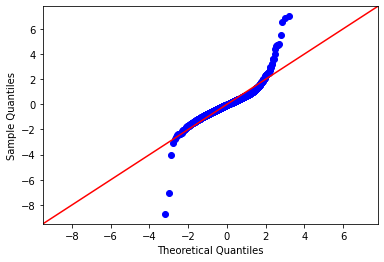

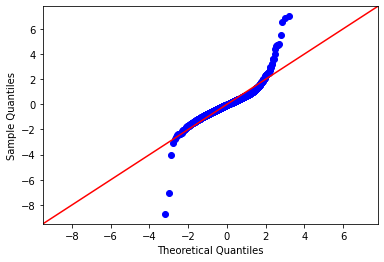

In [24]:
# model diagnostics
sm.qqplot(model_2.resid, fit = True, line = '45')

<AxesSubplot:ylabel='Count'>

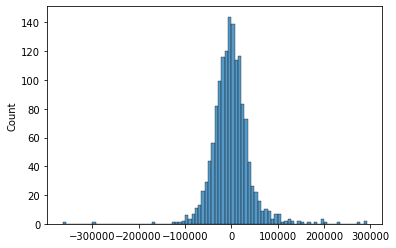

In [25]:
sns.histplot(model_2.resid)

## Model 3 - Transformations of data

Log transformation is a data transformation method in which it replaces each variable x with a log(x). In other words, the log transformation reduces or removes the skewness of our original data. The log transformation can be used to make highly skewed distributions less skewed.

In [26]:
# lets log transform the dependent variable
log_y = np.log(y)
X['GrLivArea'] = np.log(X['GrLivArea'])

In [27]:
log_y

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

In [28]:
# build a new model with the log transformed target
model_3 = sm.OLS(log_y, sm.add_constant(X)).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     673.5
Date:                Mon, 23 May 2022   Prob (F-statistic):               0.00
Time:                        15:40:08   Log-Likelihood:                 324.36
No. Observations:                1460   AIC:                            -632.7
Df Residuals:                    1452   BIC:                            -590.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.9913      0.153     52.363      0.000       7.692       8.291
OverallQual          0.1628      0.005     31.492      0.000       0.153       0.173
GrLivArea            0.3899      0.023     16.928      0.000       0.345       0.435
bldg_type_1Fam       0.1336      0.036      3.724      0.000       0.063       0.204
bldg_type_Duplex     0.0276      0.044      0.624      0.533      -0.059       0.114
bldg_type_Twnhs     -0.0711      0.047     -1.527      0.127      -0.162       0.020
bldg_type_TwnhsE     0.0945      0.041      2.312      0.021       0.014       0.175
FullBath             0.0566      0.013      4.403      0.000       0.031       0.082
==============================================================================
Omnibus:                      303.788   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1115.766
Skew:                          -0.979   Prob(JB):                    5.18e-243
Kurtosis:                       6.809   Cond. No.                         301.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

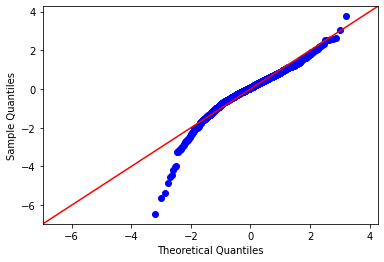

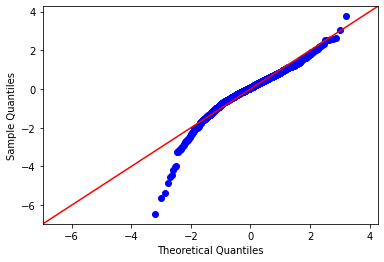

In [29]:
# model diagnostics
sm.qqplot(model_3.resid, fit = True, line = '45')

<AxesSubplot:ylabel='Count'>

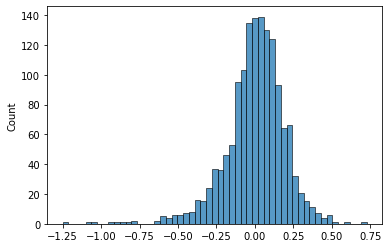

In [30]:
sns.histplot(model_3.resid)

### Checking Homoscedasticity

/Users/akulkarni/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


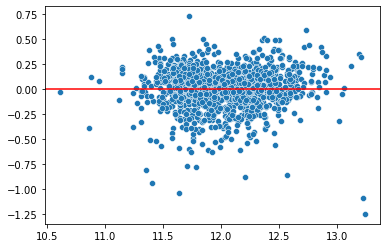

In [31]:
sns.scatterplot(model_3.predict(sm.add_constant(X)), model_3.resid)
plt.axhline(0, color = 'red')

Comment on the new plots. Did they improve? Did they get worse?